In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [4]:
cellDevsShape = (20, 20)

loadedMatrix = np.load('out.npz')
# loadedMatrix = loadedMatrix.reshape(cellDevsShape)

composedMatrix = np.zeros([cellDevsShape[0], cellDevsShape[1], len(loadedMatrix.files)], dtype=np.double)

for index, npFileName in enumerate(loadedMatrix.files):
    composedMatrix[..., index] = loadedMatrix[ npFileName ].reshape(cellDevsShape)

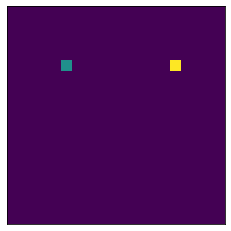

In [16]:
index = 0
fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plottedImage = ax.imshow(composedMatrix[..., index])
stepsCount = composedMatrix.shape[2]

In [17]:
def updateImage(*args):
    global index
    index += 1
    index = index % stepsCount
    plottedImage.set_array(composedMatrix[..., index])
    return plottedImage,
    
simulationAnimation = animation.FuncAnimation(fig, updateImage, interval= 100)

HTML(simulationAnimation.to_html5_video())